In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.optimize as sc_opt
import scipy.special as sc_spc

In [2]:
PS2NS=1e-3

In [3]:
def rational(x, p, q) :
    return np.polyval(p, x) / np.polyval(q + [1.0], x)
def rational_4_2(x, p0, p1, p2, p3, q1) :
    return rational(x, [p0, p1, p2, p3], [q1,])
def ratioder_4_2(x, p0, p1, p2, p3, q1) :
    return rational(x, [2*p0*q1, 3*p0+p1*q1, 2*p1, p2-p3*q1], [q1*q1, 2*q1,])
def ratiodr2_4_2(x, p0, p1, p2, p3, q1) :
    return rational(x, [2*p0*q1*q1, 6*p0*q1, 6*p0, 2*(p1-p2*q1+p3*q1*q1)], [q1**3, 3*q1*q1, 3*q1])

In [4]:
cos = lambda t : np.cos( np.deg2rad(t) )
sin = lambda t : np.sin( np.deg2rad(t) )
tan = lambda t : np.tan( np.deg2rad(t) )
cot = lambda t : 1.0/np.tan( np.deg2rad(t) )
tan_m1 = lambda t : np.rad2deg(np.arctan(t))
cos_m1 = lambda t : np.rad2deg(np.arccos(t))
sin_m1 = lambda t : np.rad2deg(np.arcsin(t))

In [5]:
sinh = lambda x, a, b, c : a*np.sinh(b-c*x)
gamma = 57.8

**--- START OF THE WORKFLOW ---**

In [6]:
folders_root = 'AmorphousSpreading/n10a02/'
folders = ['R0','R1','R2','R3','R4']

In [7]:
t = np.loadtxt(folders_root+folders[0]+'/time.txt')*PS2NS
nt = len(t)

In [8]:
def rd_m(p) :
    r = ratioder_4_2(t,*p)
    r[r>0] = 0
    return r 
def r2_p(p) :
    r = ratiodr2_4_2(t,*p)
    r[r<0] = 0
    return r

In [9]:
time_vec = []
angle_fit_vec = []
angle_l_vec = []
angle_r_vec = []
foot_l_vec = []
foot_r_vec = []
radius_fit_vec = []
sub_angle_l_vec = []
sub_angle_r_vec = []

In [10]:
for r in folders :
    time_vec.append(PS2NS*np.loadtxt(folders_root+r+'/time.txt'))
    angle_fit_vec.append(np.loadtxt(folders_root+r+'/angle_fit.txt'))
    angle_l_vec.append(np.loadtxt(folders_root+r+'/angle_l.txt'))
    angle_r_vec.append(np.loadtxt(folders_root+r+'/angle_r.txt'))
    foot_l_vec.append(np.loadtxt(folders_root+r+'/foot_l.txt'))
    foot_r_vec.append(np.loadtxt(folders_root+r+'/foot_r.txt'))
    radius_fit_vec.append(np.loadtxt(folders_root+r+'/radius_fit.txt'))
    sub_angle_l_vec.append(np.loadtxt(folders_root+r+'/sub_angle_l.txt'))
    sub_angle_r_vec.append(np.loadtxt(folders_root+r+'/sub_angle_r.txt'))

<IPython.core.display.Javascript object>


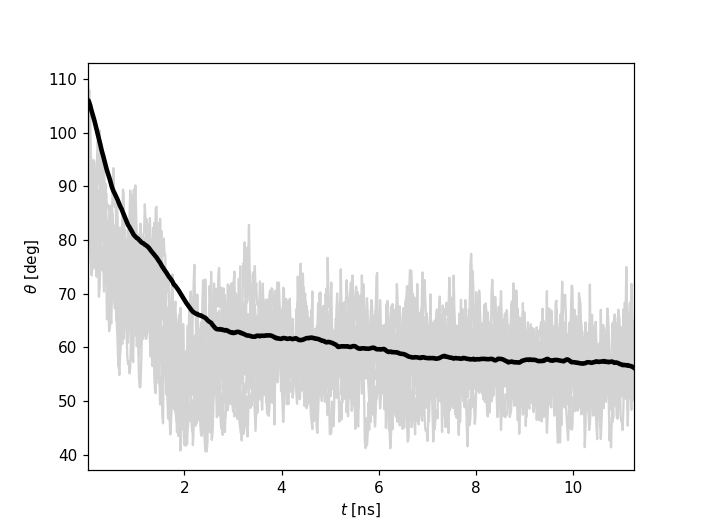

In [11]:
%matplotlib notebook
theta_avg = np.zeros(nt)
for i in range(len(folders)) :
    # theta_avg += angle_l_vec[i]
    # theta_avg += angle_r_vec[i]
    theta_avg += angle_fit_vec[i]
    plt.plot(time_vec[i],angle_l_vec[i],color="lightgray",linewidth=1.5)
    plt.plot(time_vec[i],angle_r_vec[i],color="lightgray",linewidth=1.5)
# theta_avg /= (2*len(folders))
theta_avg /= len(folders)
plt.plot(t,theta_avg,color="black",linewidth=3)
plt.xlim([t[0],t[-1]])
plt.xlabel(r'$t$ [ns]')
plt.ylabel(r'$\theta$ [deg]')
plt.show()

<IPython.core.display.Javascript object>


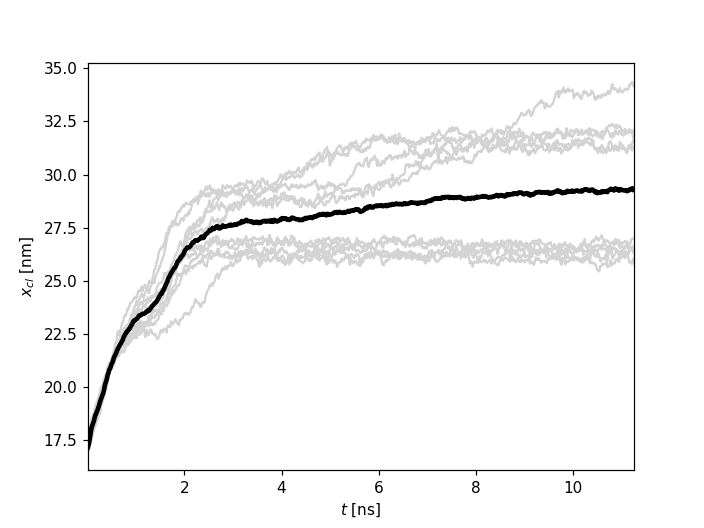

In [12]:
%matplotlib notebook
xcl_avg = np.zeros(nt)
for i in range(len(folders)) :
    x0 = 0.5*(foot_l_vec[i][0]+foot_r_vec[i][0])
    xcl_avg += x0-foot_l_vec[i]
    xcl_avg += foot_r_vec[i]-x0
    plt.plot(time_vec[i],x0-foot_l_vec[i],color="lightgray",linewidth=1.5)
    plt.plot(time_vec[i],foot_r_vec[i]-x0,color="lightgray",linewidth=1.5)
xcl_avg /= (2*len(folders))
plt.plot(t,xcl_avg,color="black",linewidth=3)
plt.xlim([t[0],t[-1]])
plt.xlabel(r'$t$ [ns]')
plt.ylabel(r'$x_{cl}$ [nm]')
plt.show()

In [13]:
np.savez('x_avg_n12a02.npz', x=t, y=xcl_avg)
np.savez('theta_g_n12a02.npz', x=t, y=theta_avg)

**--- END OF THE WORKFLOW ---**

In [14]:
X = np.load('x_avg_n12a02.npz')
t = X['x']
xcl_avg = X['y']
X = np.load('theta_g_n12a02.npz')
theta_avg = X['y']

In [15]:
p0_ls=[1,1,1,1,1]
mv=1000
lvel=10, 
lacc=1
def fres(p):
    return np.concatenate((xcl_avg-rational_4_2(t,*p),lvel*rd_m(p),lacc*r2_p(p)),axis=None)

ls_results = sc_opt.least_squares(fres,x0=p0_ls,max_nfev=mv)
popt1 = ls_results.x
x_fit = rational_4_2(t,*popt1)
v_fit = ratioder_4_2(t,*popt1)

<IPython.core.display.Javascript object>


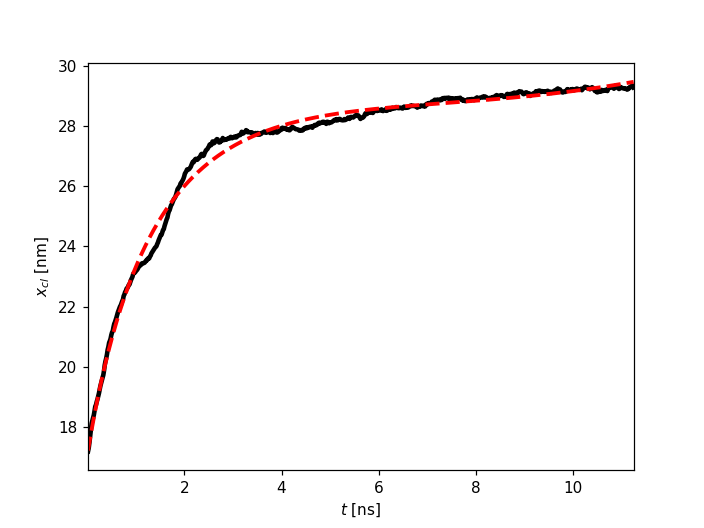

In [16]:
%matplotlib notebook
plt.plot(t,xcl_avg,color="black",linewidth=3)
plt.plot(t,x_fit,'r--',linewidth=2.5)
plt.xlim([t[0],t[-1]])
plt.xlabel(r'$t$ [ns]')
plt.ylabel(r'$x_{cl}$ [nm]')
plt.show()

In [17]:
mv=10000
# w = np.abs(v_fit)
# w /= np.sum(w)
# popt2, pcov2 = sc_opt.curve_fit(sinh,cos(theta_avg),v_fit,maxfev=mv,sigma=np.sqrt(w))
popt2, pcov2 = sc_opt.curve_fit(sinh,cos(theta_avg),v_fit,maxfev=mv)
v_mkt = sinh(cos(theta_avg),*popt2)

In [18]:
muf = gamma/popt2[0]*popt2[2]
print('------------------------------------------')
print('muf_eff = '+str(muf)+' cP')
print('------------------------------------------')

------------------------------------------
muf_eff = 13.54808699427147 cP
------------------------------------------


<IPython.core.display.Javascript object>


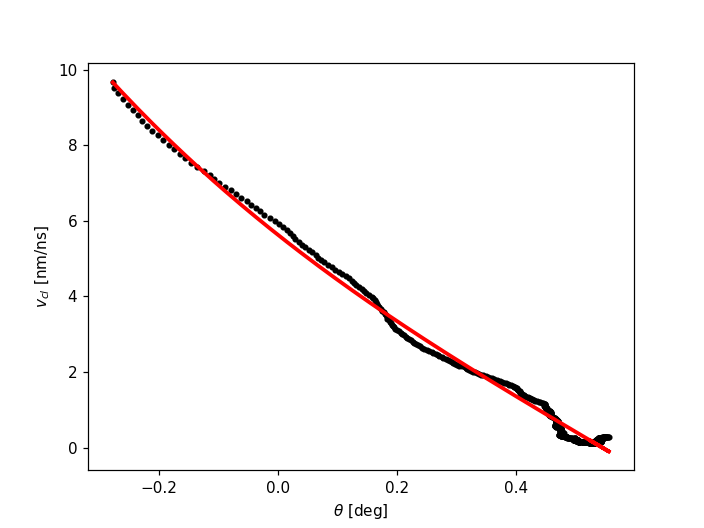

In [19]:
%matplotlib notebook
plt.plot(cos(theta_avg),v_fit,'k.',linewidth=3)
plt.plot(cos(theta_avg),v_mkt,'r-',linewidth=2.5)
plt.xlabel(r'$\theta$ [deg]')
plt.ylabel(r'$v_{cl}$ [nm/ns]')
plt.show()